In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
import copy
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic, N_conjugate_frank_wolfe 
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences
from src.admm_stuff import AdmmOracle, combined_salim, combined_salim_with_cheb

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter


plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [3]:
networks_path = Path("./TransportationNetworks")

# folder = "SiouxFalls"
# net_name = "SiouxFalls_net"
# traffic_mat_name = "SiouxFalls_trips"

# folder = "Chicago-Sketch"
# net_name = "ChicagoSketch_net"
# traffic_mat_name = "ChicagoSketch_trips"

folder = "Anaheim"
net_name = "Anaheim_net"
traffic_mat_name = "Anaheim_trips"

# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"


net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=False
graph.number_of_edges()=914, graph.number_of_nodes()=454


In [4]:
# # This cell is to add some people to replace zeros in traffic maxtrix but not making flow bigger

# tm = correspondences.traffic_mat
# print(tm.sum())
# tm[tm == 0] = 1
# tm[tm > 10] = tm[tm > 10] * 0.952
# tm.sum()

In [5]:
beckmann_model = BeckmannModel(graph, copy.deepcopy(correspondences))

# Twostage

In [6]:
traffic_mat = correspondences.traffic_mat.copy()
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0)
l, w = departures, arrivals
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)
admm_oracle = AdmmOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

/home/demyan/reps/mmo_tm/src/admm_stuff.py:24: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence_mat = nx.incidence_matrix(traffic_model.nx_graph, oriented=True).todense()


In [7]:
# exact solution via cyclic (if it converges better than salim)
output = cyclic(
    model=twostage_beckmann_model,
    traffic_assigment_eps_abs=10,  # experiment["almost_exact"]["ta_eps_abs"],
    traffic_assigment_max_iter=100,  # experiment["almost_exact"]["max_iter"],
    max_iter=10,  # experiment["meta"]["cyclic_iters"],
    stop_by_crit=False,
)

times_e_best, flows_e_best, corrs_best, logs, optimal = output
times, dgaps = logs[2], logs[0]
# experiment["almost_exact"]["times"] = times
# experiment["almost_exact"]["dgaps"] = dgaps

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


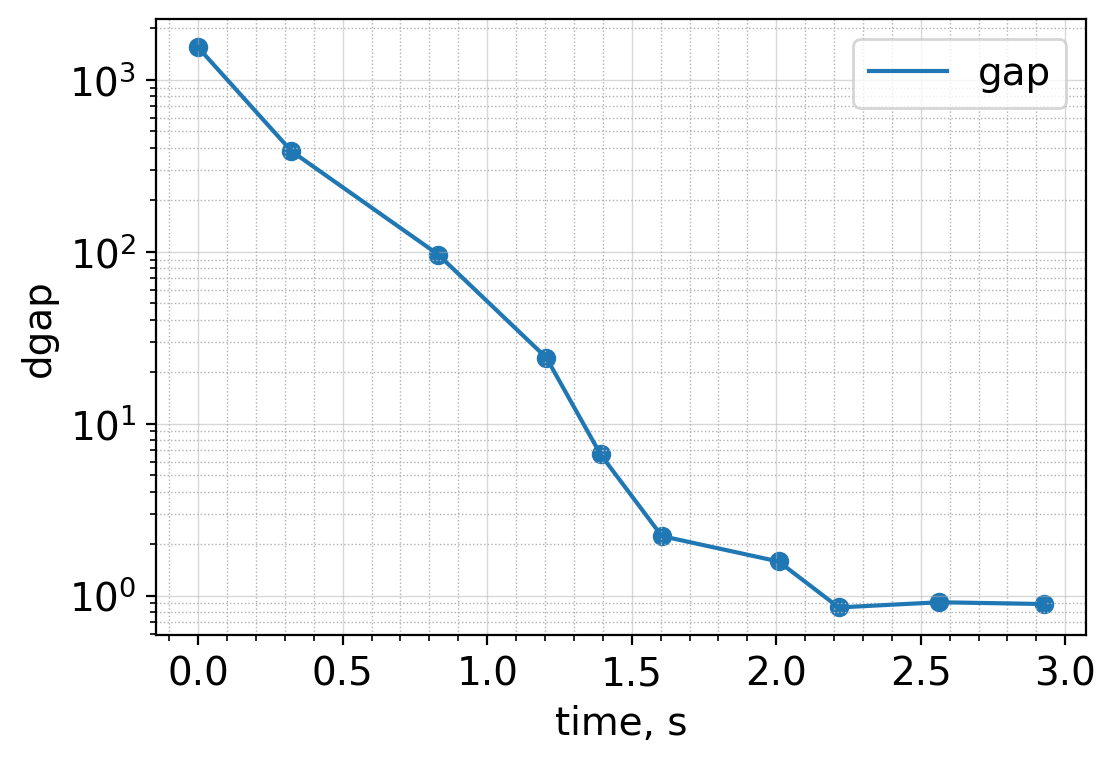

In [8]:
# times, dgaps = experiment["almost_exact"]["times"], experiment["almost_exact"]["dgaps"]
ax = plt.figure(figsize=(6, 4)).add_subplot(1, 1, 1)
ax.plot(times, dgaps, label=f"gap")
ax.scatter(times, dgaps)

ax.minorticks_on(), ax.set_yscale("log"), ax.set_ylabel("dgap"), ax.set_xlabel("time, s")
minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which="major", linestyle="-", linewidth="0.5", alpha=0.5)
ax.grid(which="minor", linestyle=":", linewidth="0.5", alpha=1)
_ = ax.legend(), plt.show()

In [9]:
# Power method for lam1
oracle = admm_oracle
hf = np.random.random((oracle.n_edges, l.size))
hd = np.random.random((l.size, l.size))
h = np.vstack((hd, hf))


def MTM(h):
    hd, hf = h[: l.size, :], h[l.size :, :]
    vf = oracle.ATmul(oracle.Amul(hf)) + oracle.ATmul(oracle.Bmul(hd))
    vd = oracle.BTmul(oracle.Amul(hf)) + oracle.BTmul(oracle.Bmul(hd)) + oracle.KTmul(oracle.Kmul(hd))
    return np.vstack((vd, vf))


for i in range(10):
    h /= np.linalg.norm(h)
    h = MTM(h)
    lmax = np.linalg.norm(h)
    print("lmax", lmax, lmax / l.size)


def MT(yAB, yK):
    vf = oracle.ATmul(yAB)
    vd = oracle.BTmul(yAB) + oracle.KTmul(yK)
    return np.vstack((vd, vf))

lmax 19.453285649921373 0.511928569734773
lmax 114.65561573755018 3.017253045725005
lmax 115.44705868572719 3.0380804917296627
lmax 115.49952369185506 3.0394611497856596
lmax 115.52041800107546 3.0400110000283016
lmax 115.52975322956063 3.0402566639358057
lmax 115.53397677345892 3.0403678098278664
lmax 115.53589285769436 3.04041823309722
lmax 115.53676270193397 3.0404411237351043
lmax 115.53715765518888 3.0404515172418125


100%|██████████| 10000/10000 [00:39<00:00, 250.23it/s]


lmin 0.043788956102474685 0.0011523409500651233


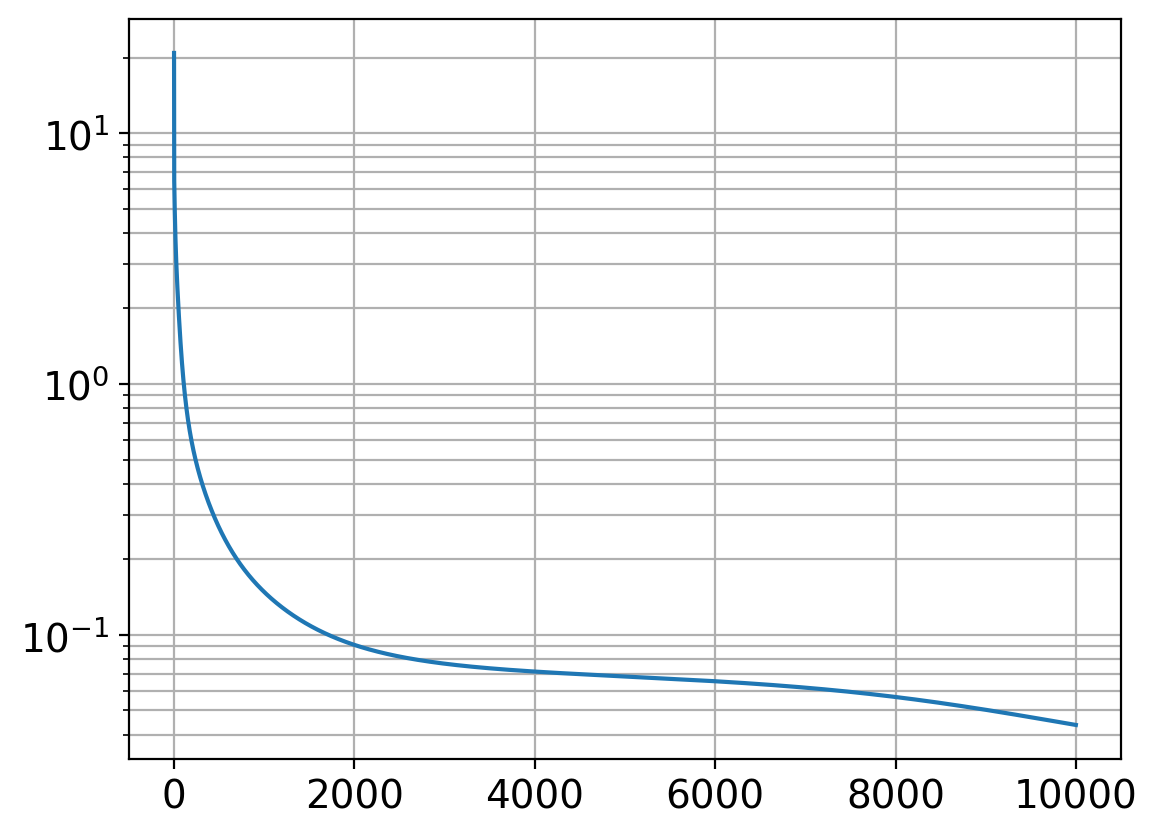

In [39]:
# in Im M^T = (Ker M)^\bot
h = MT(np.random.random(oracle.Amul(hf).shape), np.random.random(oracle.Kmul(hd).shape))
lmins = []
for i in tqdm(range(10000)):
    h /= np.linalg.norm(h)
    h = lmax * h - MTM(h)
    lmin = lmax - np.linalg.norm(h)
    lmins.append(lmin)

print("lmin", lmin, lmin / l.size)

plt.plot(lmins)
plt.grid(which="both")
plt.yscale("log")

In [11]:
# for Sioux-Falls
comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(2, -1, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {
    "meta": {
        "network": folder,
        "description": comment,
    },
    #        "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
    "cyclic_big_iters": 15,
    "cyclic_ta_iters": 10_000,
    "ta_epss": ta_epss,
    "salim_kwargs": dict(mu=1e-4, L=1, lam2=l.size, lam1=3 * l.size),
    "salim_iters": 2000,
    "salim_exact_iters": 5000,
    "data": {
        "dgapss": None,
        "timess": None,
        "distss": None,
        "salim_exact_cons": None,
        "salim_exact_opt": None,
        "salim_times": None,
        "salim_dists": None,
    },
}
data = experiment["data"]

In [18]:
salim_kwargs = dict(mu=1e-8, L=100,lam2=1e-4 * l.size, lam1=3.5*l.size)
# salim_kwargs = experiment["salim_kwargs"]
output = combined_salim(admm_oracle, **salim_kwargs, iters=3000, #=experiment["salim_iters"],
               solution_corrs=corrs_best,
               solution_flows=flows_e_best,
               )

corrs_salim, flows_salim, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output

data["salim_times"], data["salim_dists"] = times_s, dists_s

100%|██████████| 3000/3000 [00:23<00:00, 128.79it/s]

Lmax= 9.363445419397229
mumin= 0.00042146805292540954
3.3249464803961266 32.49038307469633 23.235918203442036
salim 2999


(<matplotlib.legend.Legend at 0x7fee070cb4d0>, None)

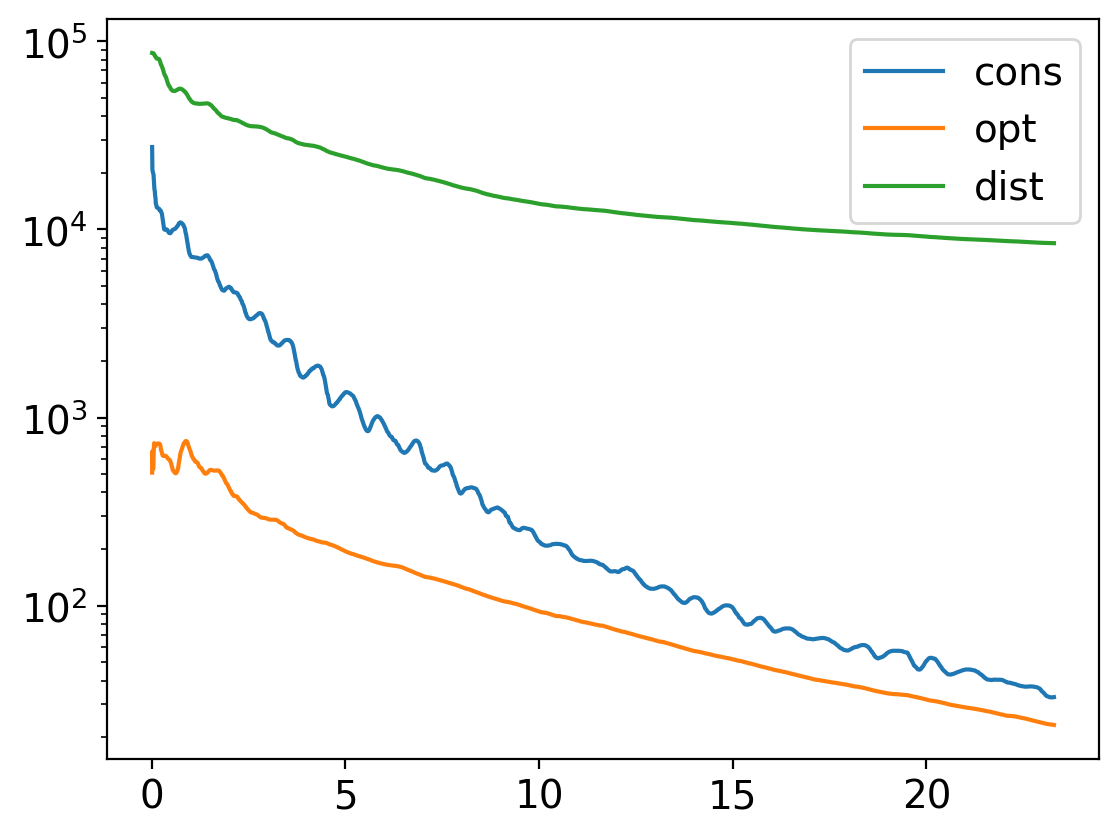

In [19]:
plt.plot(times_s, pri_res, label="cons")
plt.plot(times_s, opt, label="opt")
plt.plot(times_s, dists_s, label="dist")
plt.legend(), plt.yscale("log")


In [55]:
salim_with_cheb_kwargs = dict(mu=1e-8, L=100, lam2=1e-4 * l.size, lam1=3.5 * l.size)
# salim_kwargs = experiment["salim_kwargs"]
output = combined_salim_with_cheb(
    admm_oracle,
    **salim_with_cheb_kwargs,
    iters=500,  # =experiment["salim_iters"],
    solution_corrs=corrs_best,
    solution_flows=flows_e_best,
)

N 197


100%|██████████| 500/500 [02:50<00:00,  2.94it/s]

201.27227701225632 136.58051424465097 210.6431500214758


(<matplotlib.legend.Legend at 0x7fee055ccc50>, None)

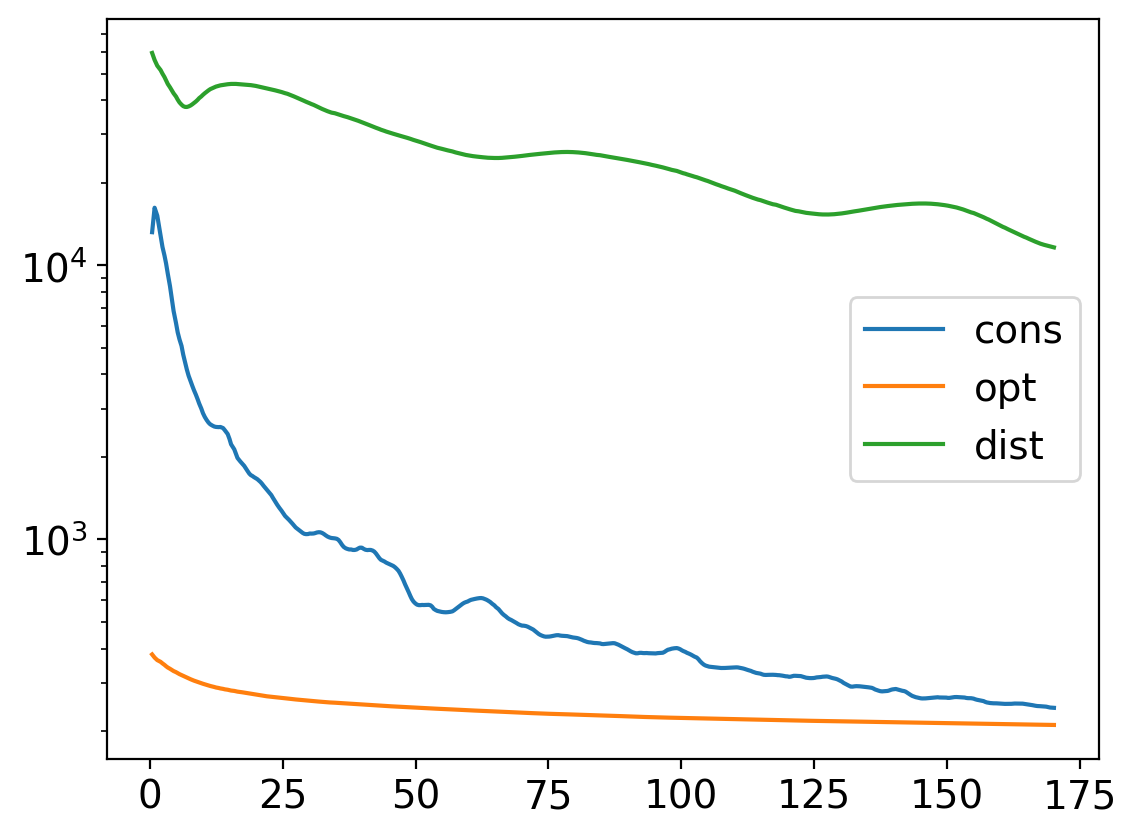

In [56]:
x_corrs, x_flows, u_corrs, u_flows, dist_s_ch, times_s_ch, pri_res_s_ch, opt_s_ch = output
plt.plot(times_s_ch, pri_res_s_ch, label="cons")
plt.plot(times_s_ch, opt_s_ch, label="opt")
plt.plot(times_s_ch, dist_s_ch, label="dist")
plt.legend(), plt.yscale("log")

In [13]:
dgapss = []
timess = []
distss = []

for ta_eps in experiment["ta_epss"]:
    output = cyclic(model=twostage_beckmann_model,
                    traffic_assigment_eps_abs=ta_eps, 
                    traffic_assigment_max_iter=experiment["cyclic_ta_iters"], 
                    max_iter=experiment["cyclic_big_iters"], 
                    stop_by_crit=False,
                    solution_flows=flows_e_best,
                    solution_corrs=corrs_best,
                   )
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = output
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgapss.append(dgap_cyclic)    
    timess.append(list(time_log_cyclic))
    distss.append(list((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5))
    
data["dgapss"] = dgapss
data["timess"] = timess 
data["distss"] = distss 

100%|██████████| 15/15 [00:44<00:00,  2.95s/it]


In [14]:
import json

with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "w") as fp:
    json.dump(experiment, fp)

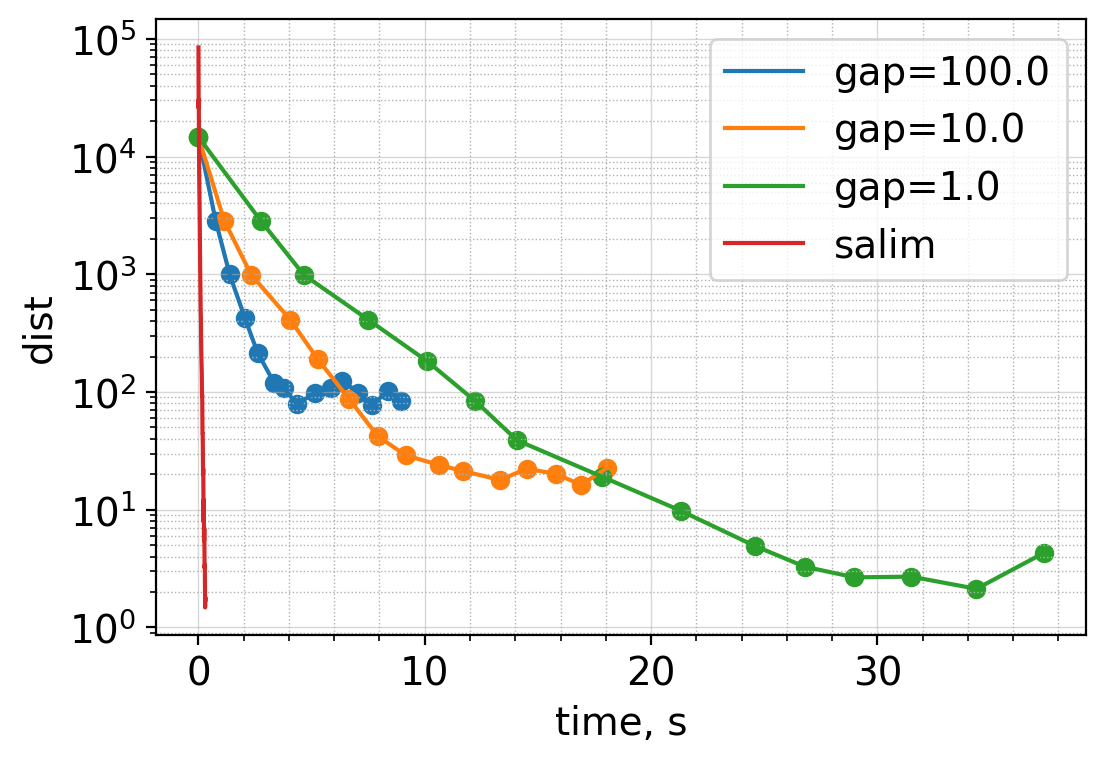

In [15]:
with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "r") as fp:
    experiment = json.load(fp)
data = experiment["data"]
    
plt.figure(figsize=(6,4))

ta_epss = experiment["ta_epss"]
for i in range(len(ta_epss)):
    times, dists = data["timess"][i], data["distss"][i] 
    plt.plot(times, dists, label=f"gap={ta_epss[i]}")
    plt.scatter(times, dists)

plt.plot(data["salim_times"], data["salim_dists"], label="salim")

plt.minorticks_on()
plt.yscale("log")

plt.ylabel("dist")
plt.xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
plt.gca().yaxis.set_minor_locator(minor_locator)

plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

plt.legend()

plt.savefig(f"experiments_data/{folder}.pdf", bbox_inches="tight")

In [ ]:
# for Chicago-sketch with
# tm = correspondences.traffic_mat
# tm[tm == 0] = 1
# tm[tm > 10] = tm[tm > 10] * 0.952

comment = "3FW in cyclic"
ta_epss = list(10.0 ** np.arange(3, 2, -1))
# agd_kwargs = dict(eps_abs=1e-4, iters=1000, M0=10)
# salim_kwargs = dict(eps_abs=1e-5, iters=1000, mu=0.01, L=1)
experiment = {"meta": {"network": folder, "description": comment, },
#        "almost_exact" : {"max_iter": 10_000, "ta_eps_abs": 1e-2},
       "almost_exact" : {},
        "cyclic_big_iters": 10,
        "cyclic_ta_iters": 100,
        "ta_epss" : ta_epss,
        "salim_kwargs" : dict(mu=1e-3, L=15,lam2=l.size/10, lam1=4*l.size),
        "salim_iters" : 2000,
        "salim_exact_iters" : 10000,
        "data" : {     
            "dgapss" : None,
            "timess" : None,
            "distss" : None,
            "salim_exact_cons" : None,
            "salim_exact_opt" : None,
            "salim_times" : None,
            "salim_dists" : None,
            },
        }
data = experiment["data"]